# Laboratorio 6 

## Javier Heredia - 21600
## Mario Cristales - 21631

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

## Preparación de los datos

In [22]:
img_size = 128
data_path = "img_align_celeba/img_align_celeba"

In [23]:
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = (img / 127.5) - 1  # Normalización entre [-1, 1]
    return img

In [24]:
image_paths = [os.path.join(data_path, filename) for filename in os.listdir(data_path)]
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

## Implementacion de la GAN

### Generador y Discriminador

In [25]:
def build_generator():
    model = tf.keras.Sequential([
        # Start with a dense layer to project the input noise vector (100) to a 8x8x256 feature map
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # Reshape to match the intended image dimensions
        layers.Reshape((8, 8, 256)),
        
        # Upsampling to 16x16
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # Upsampling to 32x32
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # Upsampling to 64x64
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # Final upsampling to 128x128, 3 channels (RGB)
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        # First convolutional block to reduce spatial dimensions (128x128 to 64x64)
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        # Second convolutional block to reduce spatial dimensions (64x64 to 32x32)
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        # Flatten the 32x32 feature maps into a single vector
        layers.Flatten(),
        layers.Dense(1)  # Output a single unit (real/fake) without activation, using logits
    ])
    return model

### Funciones de pérdida y los optimizadores

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss: Measures how well the discriminator can distinguish real images from fake ones.
def discriminator_loss(real_output, fake_output):
    # Real images should be classified as 1 (real)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Fake images should be classified as 0 (fake)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss: Measures how well the generator can fool the discriminator.
def generator_loss(fake_output):
    # The generator wants the discriminator to classify its fake images as 1 (real)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer for the generator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Optimizer for the discriminator
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Entrenamiento de la GAN

In [27]:
import time

@tf.function
def train_step(real_images, generator, discriminator, generator_optimizer, discriminator_optimizer, noise_dim):
    # Generate random noise for the generator
    noise = tf.random.normal([real_images.shape[0], noise_dim])

    # GradientTape for discriminator and generator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get discriminator outputs for real and fake images
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate the generator and discriminator losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients for both networks
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, noise_dim, save_interval=100):
    for epoch in range(epochs):
        print(f'Iniciando época {epoch + 1}')
        for image_batch in dataset:
            print(f'Entrenando batch {image_batch + 1} de {len(dataset)}')
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer, noise_dim)

        print(f'Tiempo para la época {epoch + 1} es {time.time() - start:.2f} segundos')
        
        # Print loss every few epochs
        if (epoch + 1) % save_interval == 0:
            generate_and_save_images(generator, noise_dim, epoch)

Iniciando entrenamiento...
Iniciando época 1
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando b

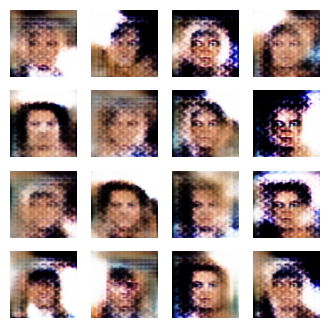

Iniciando época 2
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando 

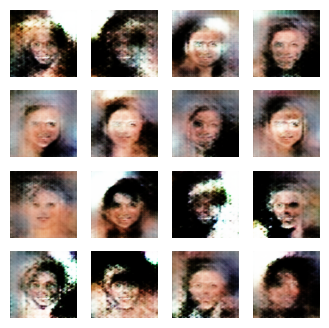

Iniciando época 3
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando 

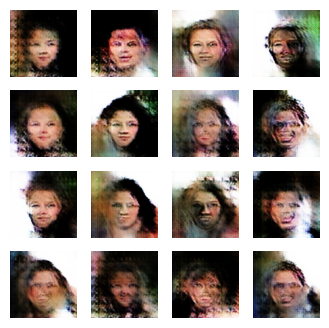

Iniciando época 4
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando 

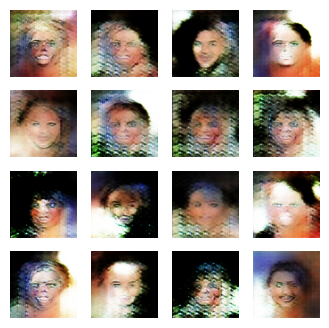

Iniciando época 5
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando 

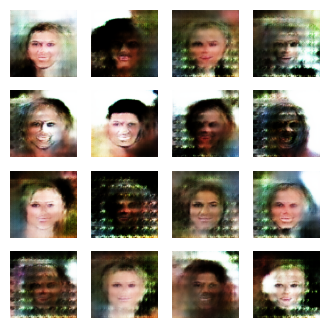

Iniciando época 6
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando 

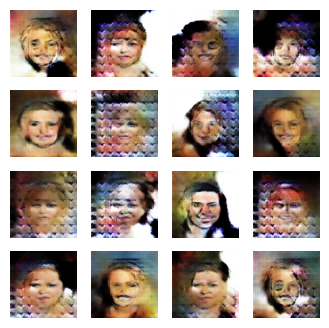

Iniciando época 7
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando 

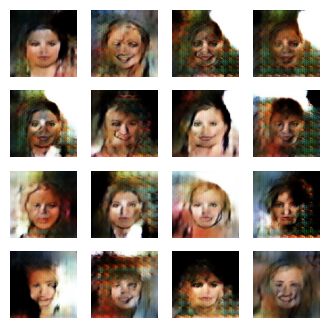

Iniciando época 8
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando 

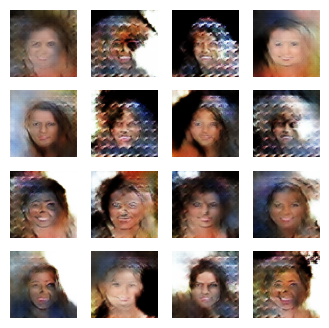

Iniciando época 9
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando 

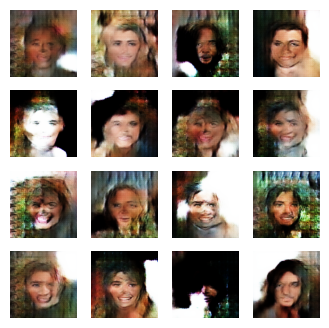

Iniciando época 10
Entrenando batch 1 de 3166
Entrenando batch 2 de 3166
Entrenando batch 3 de 3166
Entrenando batch 4 de 3166
Entrenando batch 5 de 3166
Entrenando batch 6 de 3166
Entrenando batch 7 de 3166
Entrenando batch 8 de 3166
Entrenando batch 9 de 3166
Entrenando batch 10 de 3166
Entrenando batch 11 de 3166
Entrenando batch 12 de 3166
Entrenando batch 13 de 3166
Entrenando batch 14 de 3166
Entrenando batch 15 de 3166
Entrenando batch 16 de 3166
Entrenando batch 17 de 3166
Entrenando batch 18 de 3166
Entrenando batch 19 de 3166
Entrenando batch 20 de 3166
Entrenando batch 21 de 3166
Entrenando batch 22 de 3166
Entrenando batch 23 de 3166
Entrenando batch 24 de 3166
Entrenando batch 25 de 3166
Entrenando batch 26 de 3166
Entrenando batch 27 de 3166
Entrenando batch 28 de 3166
Entrenando batch 29 de 3166
Entrenando batch 30 de 3166
Entrenando batch 31 de 3166
Entrenando batch 32 de 3166
Entrenando batch 33 de 3166
Entrenando batch 34 de 3166
Entrenando batch 35 de 3166
Entrenando

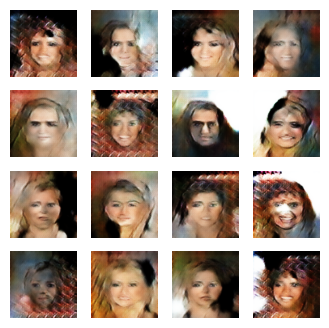

In [28]:
# Helper function to generate and save images during training
def generate_and_save_images(generator, noise_dim, epoch):
    noise = tf.random.normal([16, noise_dim])  # Generate noise
    generated_images = generator(noise, training=False)  # Generate images from noise

    generated_images = (generated_images + 1) / 2.0  # Rescale images from [-1, 1] to [0, 1]

    fig = plt.figure(figsize=(4, 4))

    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')

    plt.savefig(f'generated_images_epoch_{epoch+1}.png')
    plt.show()

# Set hyperparameters
noise_dim = 100  # Size of the noise vector
batch_size = 64
epochs = 10  # You can adjust this depending on your training goals
save_interval = 100  # Save and display generated images every 100 epochs

# Build the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Load and preprocess the dataset
def preprocess_images(image):
    image = (image - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return image

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,  # Path to your dataset folder
    label_mode=None,
    image_size=(128, 128),
    batch_size=batch_size
).map(preprocess_images)  # Apply preprocessing

# Prefetch for efficiency
dataset = dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the GAN
train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, noise_dim, save_interval)


## Visualización de resultados

In [32]:
def evaluate_diversity(generator, num_examples=100, noise_dim=100):
    # Generate random noise vectors and create images using the generator
    noise = tf.random.normal([num_examples, noise_dim])
    generated_images = generator(noise, training=False)

    # Convert generated images to a numpy array for easier statistical computation
    images_np = generated_images.numpy()

    # Compute pixel-wise variance across the generated examples (variance along the batch dimension)
    pixel_variances = np.var(images_np, axis=0)

    # Calculate the average variance across all pixels
    avg_variance = np.mean(pixel_variances)
    
    print(f'Average pixel variance across generated images: {avg_variance:.4f}')
    
    return avg_variance

# Example usage after training the GAN:
evaluate_diversity(generator, num_examples=100, noise_dim=noise_dim)


Average pixel variance across generated images: 0.2931


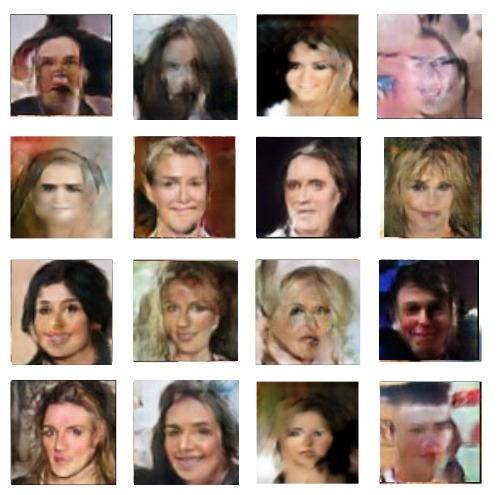

In [5]:
def evaluate_generator(generator, num_examples=16, noise_dim=100):
    # Generate random noise for the generator
    noise = tf.random.normal([num_examples, noise_dim])
    
    # Generate images from the noise
    generated_images = generator(noise, training=False)
    
    # Visualize the generated images in a grid
    fig = plt.figure(figsize=(4, 4))

    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = generated_images[i].numpy()  # Convert the image to a NumPy array
        plt.imshow((img * 127.5 + 127.5).astype(np.uint8))  # Rescale from [-1, 1] to [0, 255]
        plt.axis('off')

    plt.show()

# Example usage after training the GAN:
evaluate_generator(generator, num_examples=16, noise_dim=noise_dim)

##  Reflexión sobre el uso de un modelo de IAGen y el laboratorio

### 1. ¿Qué conceptos de la teoría encontraron más desafiantes y por qué?

Uno de los conceptos más desafiantes fue la idea de equilibrio entre el generador y el discriminador. En las GANs, es esencial que ambas redes se entrenen de manera equilibrada: si el generador mejora demasiado rápido, el discriminador no puede seguir el ritmo, y si el discriminador es demasiado fuerte, el generador no tiene la oportunidad de aprender. Este equilibrio es difícil de lograr y puede llevar a inestabilidad en el entrenamiento, un fenómeno conocido como "mode collapse" donde el generador produce imágenes muy similares en lugar de una variedad diversa.

### 2. ¿Cómo les ayudó el laboratorio a consolidar o entender mejor estos conceptos?

El laboratorio nos permitió entender mejor estos conceptos mediante la experimentación práctica con las GANs. Al trabajar con el dataset CelebA, pudimos visualizar cómo las imágenes generadas evolucionaban con el tiempo, lo que nos ayudó a comprender los desafíos en la estabilidad del entrenamiento. Implementar funciones como la evaluación de la diversidad a través de la varianza de los píxeles nos dio una idea clara de cómo el generador puede caer en "mode collapse" y cómo detectar este problema de manera cuantitativa

### 3. ¿Qué aplicaciones potenciales ven para las GANs en la industria o en la investigación?

Las GANs tienen aplicaciones potenciales en diversas áreas tanto en la industria como en la investigación. En el caso del dataset CelebA, podrían utilizarse para generar rostros realistas que podrían aplicarse en el cine o los videojuegos para crear personajes más realistas. Además, las GANs se están utilizando en la mejora de la resolución de imágenes (superresolución), la síntesis de datos (creación de datos sintéticos para entrenar otros modelos), y la investigación en medicina para generar imágenes médicas artificiales que pueden ayudar en la investigación y entrenamiento de otros modelos de IA sin comprometer la privacidad de los pacientes.

### 4. ¿Qué limitaciones o preocupaciones éticas pueden identificar en el uso de GANs?

Una de las principales preocupaciones éticas con el uso de GANs es la posibilidad de crear imágenes falsas que sean indistinguibles de las reales, lo que puede llevar a la creación de contenido falso (como deepfakes) que podría ser utilizado con fines maliciosos, como en campañas de desinformación o suplantación de identidad. Además, el uso de datos sensibles como rostros humanos, como en el caso de CelebA, plantea cuestiones sobre la privacidad y el consentimiento, ya que los modelos podrían replicar características personales sin el permiso de los individuos.


### 5. ¿Cómo se sienten con respecto a la implementación y entrenamiento de GANs después de la experiencia práctica?

Después de la experiencia práctica, me siento mucho más cómodo con la implementación y entrenamiento de GANs. Al principio, los desafíos teóricos, como mantener el equilibrio entre el generador y el discriminador, parecían intimidantes. Sin embargo, la práctica con código y la experimentación con diferentes configuraciones de hiperparámetros me ayudaron a comprender mejor cómo abordar estos problemas. Además, el proceso de visualización y evaluación de las imágenes generadas nos permitió ver los resultados tangibles del modelo, lo que fue una experiencia muy gratificante.